### Pneumonia Detection Stacked model(94%)

In [54]:
# making all imports 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import os
import glob
import json
from PIL import ImageFont
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import visualkeras
from keras.preprocessing.image import ImageDataGenerator, load_img

import tensorflow as tf
import keras

import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### creating the path

In [2]:
main_dir = "../DataSet1/chest-xray-pneumonia/chest_xray/"
train_data_dir = main_dir + "train/"
validation_data_dir = main_dir + "val/"
test_data_dir = main_dir + "test/"


print("Working Directory Contents:", os.listdir(main_dir))

# creating path is really important when we deal with multiple folder and files 

Working Directory Contents: ['val', 'test', 'train', '.DS_Store']


In [3]:
train_n = train_data_dir+'NORMAL/'
train_p = train_data_dir+'PNEUMONIA/'

print("length of cases in training set:",len(os.listdir(train_p)) + len(os.listdir(train_n)))
print("length of pneumonia cases in training set:",len(os.listdir(train_p)))
print("length of normal cases in training set:",len(os.listdir(train_n)))

length of cases in training set: 5216
length of pneumonia cases in training set: 3875
length of normal cases in training set: 1341


### Some image processing can help us to understand the xray

for image processing we create a function and put in lambda layer in our model, for Xray-classification i have found out the CLAHE and image normalization helps up to get better result

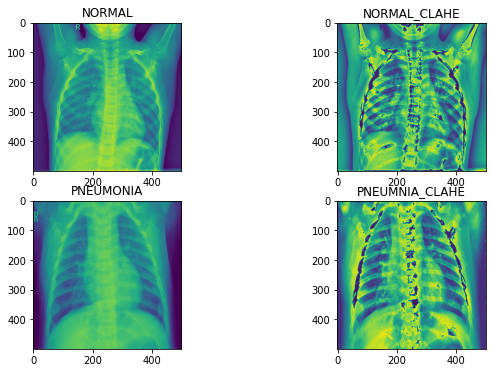

In [4]:
# Quick look to the images 
clahe = cv2.createCLAHE(clipLimit = 5)


img_name = 'IM-0115-0001.jpeg'
img_normal = cv2.imread('../DataSet1/chest-xray-pneumonia/chest_xray/train/NORMAL/' + img_name)
img_normal = cv2.resize(img_normal, (500,500))
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY)
img_normal_clahe = clahe.apply(img_normal) + 30



img_name_1 = 'person1000_virus_1681.jpeg'
img_pneumonia = cv2.imread('../DataSet1/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/' + img_name_1)
img_pneumonia = cv2.resize(img_pneumonia, (500,500))
img_pneumonia = cv2.cvtColor(img_pneumonia, cv2.COLOR_BGR2GRAY)
img_pneumonia_clahe = clahe.apply(img_pneumonia) + 30


#-----------------------------------------------------------------------------------------#


fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0,0].imshow(img_normal)
axs[0,0].set_title("NORMAL")
axs[0,1].imshow(img_normal_clahe)
axs[0,1].set_title("NORMAL_CLAHE")
axs[1,0].imshow(img_pneumonia)
axs[1,0].set_title("PNEUMONIA")
axs[1,1].imshow(img_pneumonia_clahe)
axs[1,1].set_title("PNEUMNIA_CLAHE");
plt.savefig("Images.png")

### Creating the generator for fitting to the model

we need generator because training big amount of images can take us to memory insufficient error here generator will do all our image processing task for training

In [5]:
### here we will apply image augumentation only on the training images not on testing or validation 
img_width , img_height = [224,224]
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2,1.0],
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


here we can draw some batch to see how our image looks like after data augmentation its a good practice to see our data after augumentation

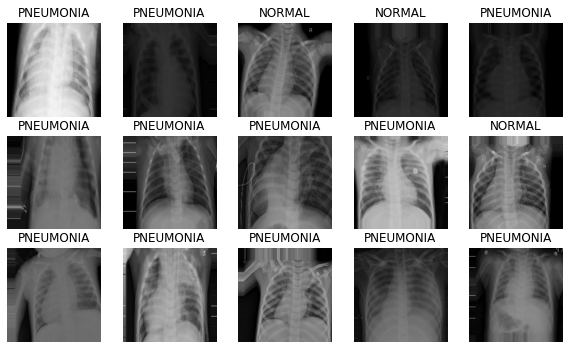

In [6]:
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
    plt.savefig("Dataset_images.png")

show_batch(image_batch, label_batch)

In [7]:
nb_train_samples = 5216 # number of training samples
nb_validation_samples = 16 # number of validation samples
nb_test_samples = 624 # number of training samples
epochs = 20  # number of epochs we gonna run
batch_size  = 16 # batch size ( at every iteration it will take 16 batches for training)

# Defining some function for plotting and Testing

Defining a function for plotting history object

In [25]:
# for plotting learning curve 
def ploting(history, name):

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(training_accuracy))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.savefig(name + ".png")
    plt.show()

For testing purpose we created a function

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = image/255
    image = cv2.resize(image, (224,224))
    return image


def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict(image , model)[0][0])
    
    final_base_pred  = np.where(np.array(base_pred)>0.5,1,0)
    actual_label = test_df['label']
    # print(final_base_pred)

    print(classification_report(actual_label, final_base_pred))
    matrix=confusion_matrix(actual_label, final_base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

The function we have created for testing takes a dataframe

In [27]:
# for evaluation point of view i have created a dataframe of test directory 
test_data = []
test_normal_path = test_data_dir + '/NORMAL'
test_pneumonia_path = test_data_dir + '/PNEUMONIA'
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))
for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path,filename),1))    
    
test_df = pd.DataFrame(test_data, columns = ['img_path','label'], index = None)
# this test_df must contain the img_path and label column in order to run the function 

# Defining the model

Here we are going to use Pretrained models for better accuracy since our Custom CNN didn't give good results

## 1. DenseNet169

In [8]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

base = DenseNet169(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable =  False # freezing densenet layers 

densenet_model = Sequential()
densenet_model.add(base)
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(1, activation='sigmoid'))

densenet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1664)              6656      
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

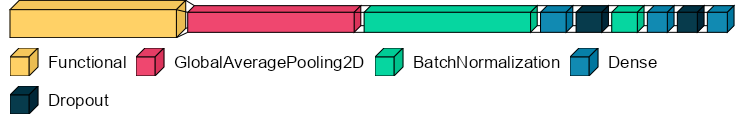

In [56]:
font = ImageFont.truetype("arial.ttf", 17)
visualkeras.layered_view(densenet_model, to_file='layered_view_densenet.png', font=font, legend=True)

In [10]:
# defined optimizer
optm = Adam(lr=0.0001)
densenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=7,
                              verbose=1,
                              mode='max',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=3,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./densenet169.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [11]:
### Training our model
dense_history = densenet_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,
                           
                              callbacks=[EarlyStopping, model_save,rlr])

Epoch 1/20
326/326 [==============================] - 272s 815ms/step - loss: 0.9618 - accuracy: 0.5397 - val_loss: 0.3750 - val_accuracy: 0.8510

Epoch 00001: val_loss improved from inf to 0.37499, saving model to ./densenet169.h5
Epoch 2/20
326/326 [==============================] - 270s 829ms/step - loss: 0.3939 - accuracy: 0.8333 - val_loss: 0.3276 - val_accuracy: 0.8702

Epoch 00002: val_loss improved from 0.37499 to 0.32755, saving model to ./densenet169.h5
Epoch 3/20
326/326 [==============================] - 272s 834ms/step - loss: 0.2822 - accuracy: 0.8883 - val_loss: 0.3008 - val_accuracy: 0.8814

Epoch 00003: val_loss improved from 0.32755 to 0.30081, saving model to ./densenet169.h5
Epoch 4/20
326/326 [==============================] - 263s 806ms/step - loss: 0.2487 - accuracy: 0.8992 - val_loss: 0.2908 - val_accuracy: 0.8862

Epoch 00004: val_loss improved from 0.30081 to 0.29084, saving model to ./densenet169.h5
Epoch 5/20
326/326 [==============================] - 263s 8

### Save model

In [13]:
densenet_model.save("Densenet_model_after_training.h5")

In [28]:
# its always a good practice to load the model after saving with the best epochs 
densenet_model = keras.models.load_model('./densenet169.h5')

### Defining some function for plotting and Testing

Defining a function for plotting history object

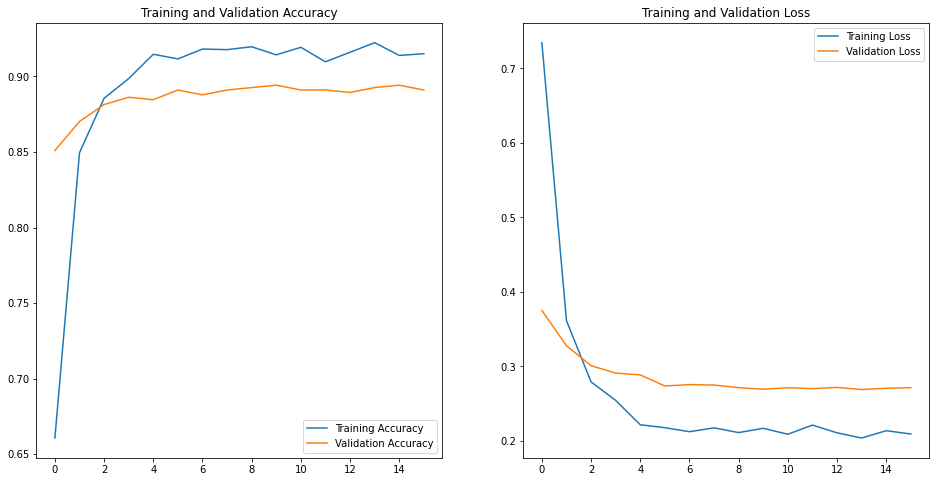

In [29]:
ploting(dense_history, "Dense_History_Densenet_model")

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       234
           1       0.90      0.94      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



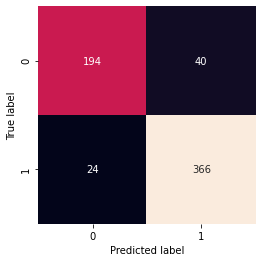

In [30]:
testing(densenet_model, test_df)

### 2. MobilenetV2

In [31]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape= (224, 224, 3))
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

mobilenet_model = Sequential()
mobilenet_model.add(base)
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(128, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(Dense(1, activation='sigmoid'))

mobilenet_model.summary()

9412608/9406464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
___________________________________________________________

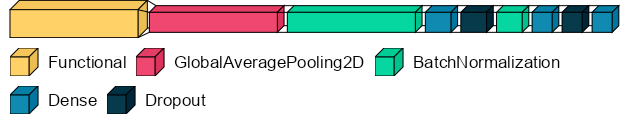

In [57]:
font = ImageFont.truetype("arial.ttf", 17)
visualkeras.layered_view(mobilenet_model, to_file='layered_view_mobilenet.png', font=font, legend=True)

In [33]:
# defined optimizer
optm = Adam(lr=0.0001)
mobilenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.001,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=4,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./mobilenet.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


### Training our model
mobilenet_history = mobilenet_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,
                           
                              callbacks=[EarlyStopping, model_save,rlr])

Epoch 1/20
326/326 [==============================] - 117s 352ms/step - loss: 0.8251 - accuracy: 0.5829 - val_loss: 0.3541 - val_accuracy: 0.8590

Epoch 00001: val_loss improved from inf to 0.35415, saving model to ./mobilenet.h5
Epoch 2/20
326/326 [==============================] - 112s 343ms/step - loss: 0.3639 - accuracy: 0.8403 - val_loss: 0.2753 - val_accuracy: 0.8958

Epoch 00002: val_loss improved from 0.35415 to 0.27528, saving model to ./mobilenet.h5
Epoch 3/20
326/326 [==============================] - 101s 309ms/step - loss: 0.2986 - accuracy: 0.8676 - val_loss: 0.2407 - val_accuracy: 0.9038

Epoch 00003: val_loss improved from 0.27528 to 0.24072, saving model to ./mobilenet.h5
Epoch 4/20
326/326 [==============================] - 101s 309ms/step - loss: 0.2890 - accuracy: 0.8757 - val_loss: 0.2319 - val_accuracy: 0.9071

Epoch 00004: val_loss improved from 0.24072 to 0.23188, saving model to ./mobilenet.h5
Epoch 5/20
326/326 [==============================] - 101s 309ms/ste

### Save model

In [35]:
mobilenet_model.save("Mobilenet_model_after_training.h5")

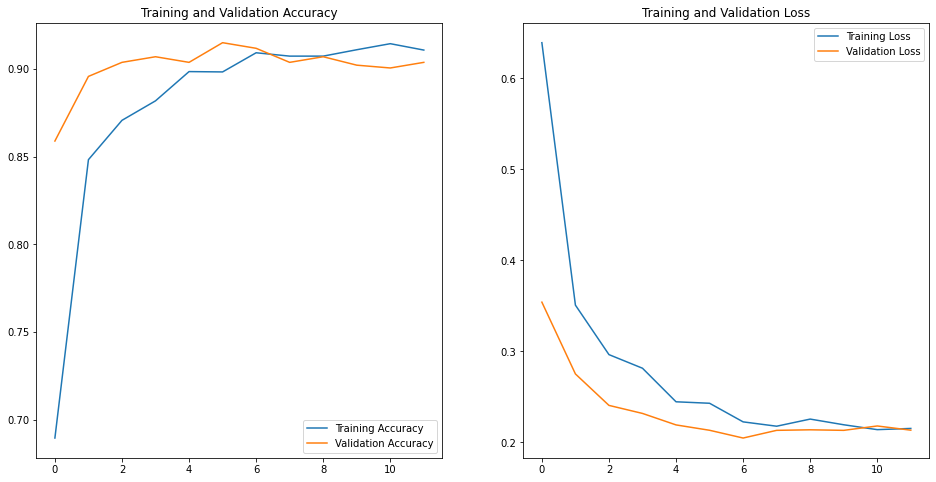

In [36]:
ploting(mobilenet_history, "Dense_History_Mobilenet_model")

In [37]:
mobilenet_model = keras.models.load_model('./mobilenet.h5')

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       234
           1       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



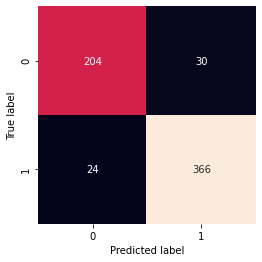

In [38]:
testing(mobilenet_model, test_df)

### 3. Stacked Model (MobilenetV2, Densenet169)

In [39]:
from keras.layers.merge import concatenate
from keras.layers import Input
import tensorflow as tf

input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))

#first model
base_mobilenet = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = input_shape)
base_densenet = DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_shape)

for layer in base_mobilenet.layers:
    layer.trainable =  False
for layer in base_densenet.layers:
    layer.trainable = False
    
model_mobilenet = base_mobilenet(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)

model_densenet = base_densenet(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

merged = tf.keras.layers.Concatenate()([output_mobilenet, output_densenet]) 

x = BatchNormalization()(merged)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)
stacked_model = tf.keras.models.Model(inputs = input_layer, outputs = x)

In [40]:
stacked_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     input_1[0][0]                    
__________________________________________________________________________________________________
densenet169 (Functional)        (None, 7, 7, 1664)   12642880    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1280)         0           mobilenetv2_1.00_224[0][0]       
______________________________________________________________________________________________

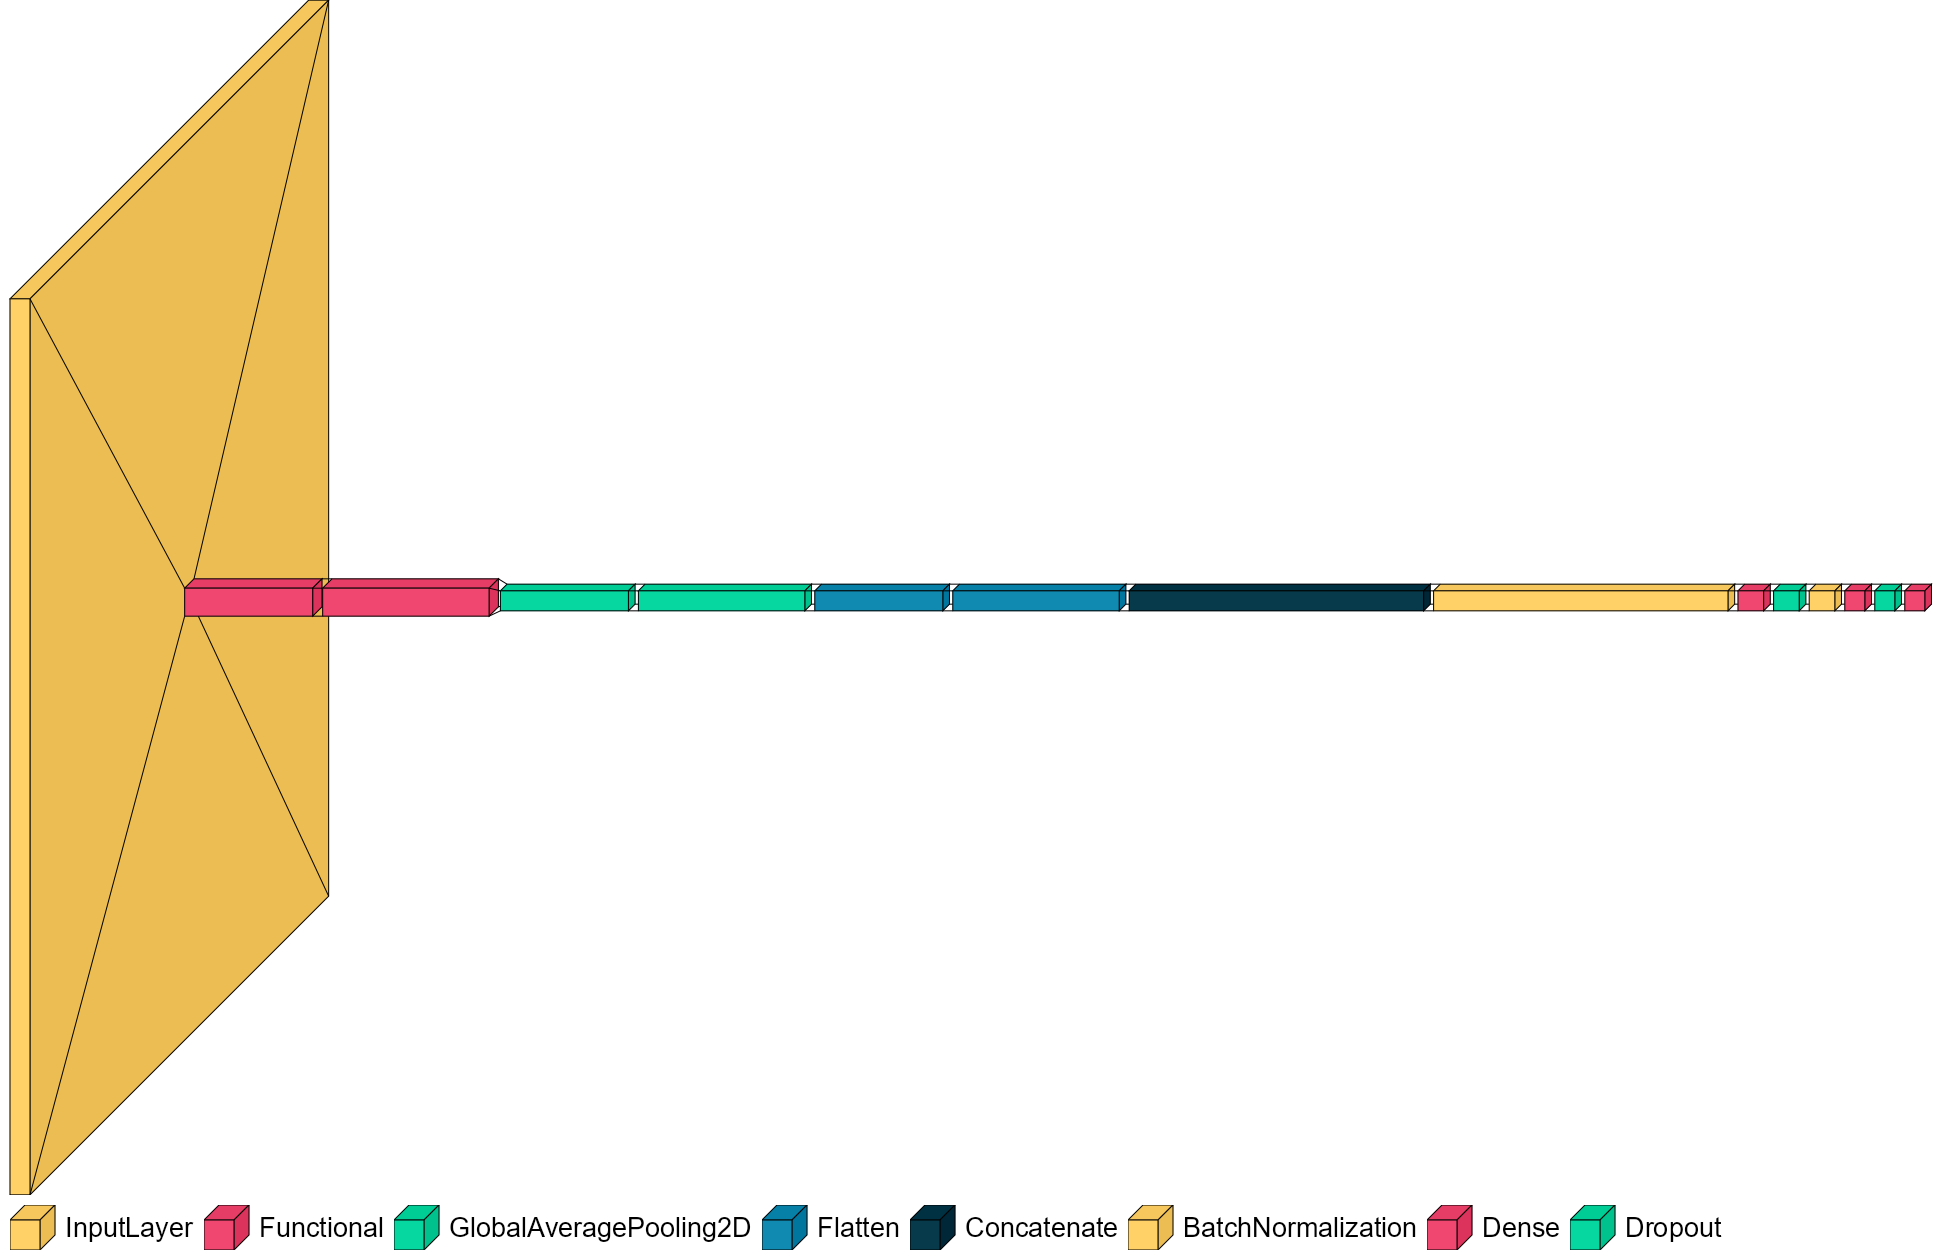

In [59]:
font = ImageFont.truetype("arial.ttf", 27)
visualkeras.layered_view(stacked_model, to_file='layered_view_stacked.png', font=font, legend=True)

In [42]:
# defined optimizer
optm = Adam(lr=0.0001)
stacked_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=6,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./stacked_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


### Training our model
stacked_history = stacked_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,
                           
                              callbacks=[EarlyStopping, model_save,rlr])

Epoch 1/20
326/326 [==============================] - 628s 2s/step - loss: 0.4834 - accuracy: 0.7743 - val_loss: 0.2514 - val_accuracy: 0.9135

Epoch 00001: val_loss improved from inf to 0.25142, saving model to ./stacked_model.h5
Epoch 2/20
326/326 [==============================] - 638s 2s/step - loss: 0.2719 - accuracy: 0.8915 - val_loss: 0.1996 - val_accuracy: 0.9183

Epoch 00002: val_loss improved from 0.25142 to 0.19960, saving model to ./stacked_model.h5
Epoch 3/20
326/326 [==============================] - 590s 2s/step - loss: 0.2050 - accuracy: 0.9188 - val_loss: 0.1900 - val_accuracy: 0.9199

Epoch 00003: val_loss improved from 0.19960 to 0.19003, saving model to ./stacked_model.h5
Epoch 4/20
326/326 [==============================] - 577s 2s/step - loss: 0.2084 - accuracy: 0.9200 - val_loss: 0.1813 - val_accuracy: 0.9247

Epoch 00004: val_loss improved from 0.19003 to 0.18131, saving model to ./stacked_model.h5
Epoch 5/20
326/326 [==============================] - 611s 2s/st

## Save model

In [43]:
stacked_model.save("Stacked_model_after_training.h5")

In [44]:
stacked_model = keras.models.load_model('./stacked_model.h5')

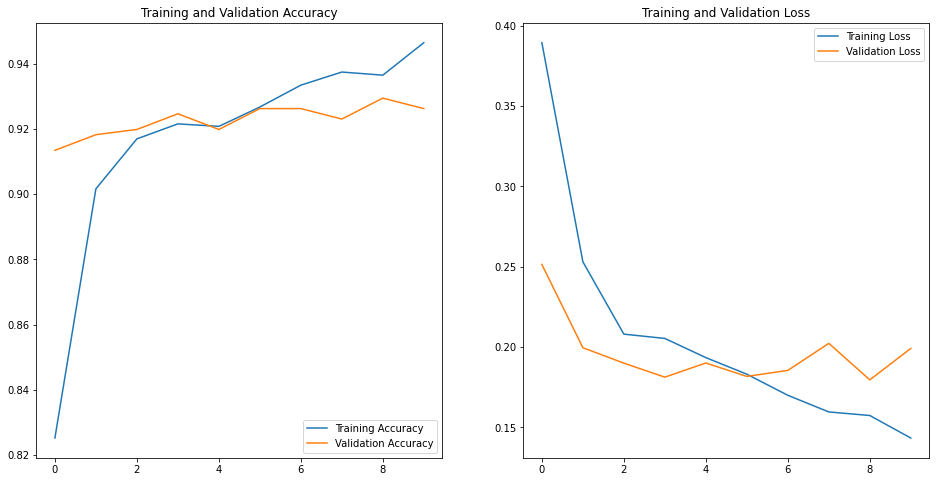

In [60]:
ploting(stacked_history, "Dense_History_Stacked_model")

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       234
           1       0.94      0.94      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



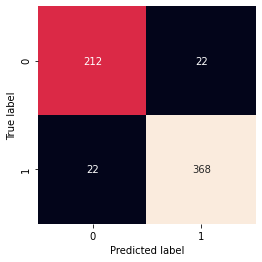

In [45]:
testing(stacked_model,test_df)

Lets test our validation _df

In [46]:
#### Lets do some prediction on our validation data 
# for evaluation point of view i have created a dataframe of test directory 
validation_data = []
validation_normal_path = validation_data_dir + '/NORMAL'
validation_pneumonia_path = validation_data_dir + '/PNEUMONIA'
for filename in os.listdir(validation_normal_path):
    validation_data.append((os.path.join(validation_normal_path,filename),0))
for filename in os.listdir(validation_pneumonia_path):
    validation_data.append((os.path.join(validation_pneumonia_path,filename),1))

In [47]:
validation_df = pd.DataFrame(validation_data, columns = ['img_path','label'], index = None)
validation_df = validation_df.sample(frac=1).reset_index(drop=True)

In [48]:
validation_df.head()

,img_path,label
0,../DataSet1/chest-xray-pneumonia/chest_xray/va...,1
1,../DataSet1/chest-xray-pneumonia/chest_xray/va...,0
2,../DataSet1/chest-xray-pneumonia/chest_xray/va...,1
3,../DataSet1/chest-xray-pneumonia/chest_xray/va...,0
4,../DataSet1/chest-xray-pneumonia/chest_xray/va...,0


### Testing all models on validation data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



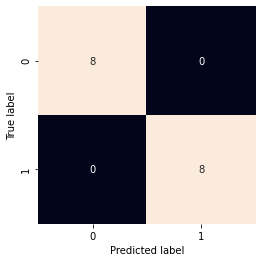

In [49]:
testing(stacked_model, validation_df)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



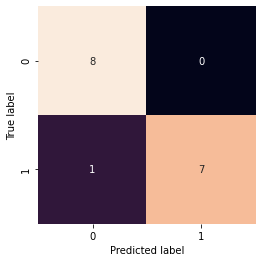

In [50]:
testing(mobilenet_model, validation_df)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



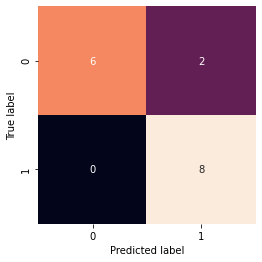

In [51]:
testing(densenet_model, validation_df)

### Testing on our DATA

In [52]:
def predict_image(validation_df, model):
    plt.figure(figsize=(6,6))
    for index , data in validation_df[:10].iterrows():
        img_name = data['img_path']
        label = data['label']
    
        label_predicted = np.where((predict(img_name , model)[0][0])>0.5,'pneumonia','normal')
        plt.imshow(load_img(img_name, target_size = (120,120)))
        if label == 1:
            plt.xlabel(f"True:Pneumonia, Predicted:{label_predicted}", fontsize = 15)
            plt.savefig(f"True:Pneumonia, Predicted:{label_predicted}")
        if label == 0:
            plt.xlabel(f"True:Normal, Predicted:{label_predicted}", fontsize = 15)
            plt.savefig(f"True:Normal, Predicted:{label_predicted}")
            
        plt.tight_layout()
        plt.show()

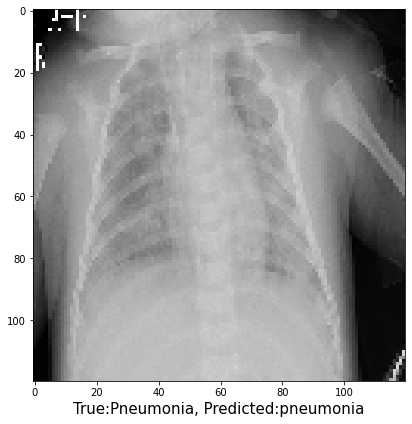

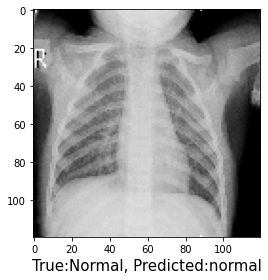

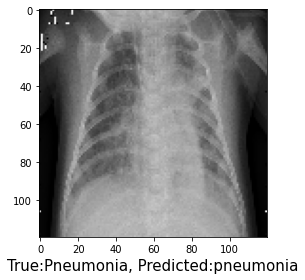

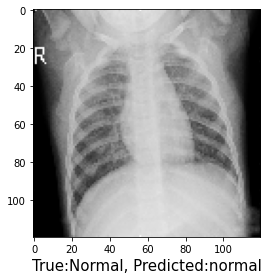

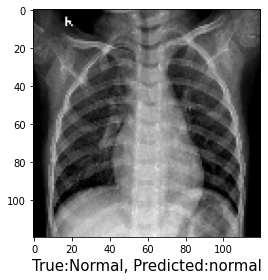

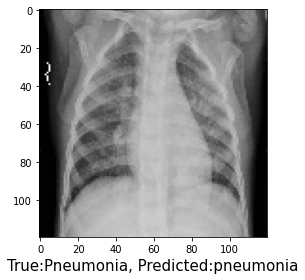

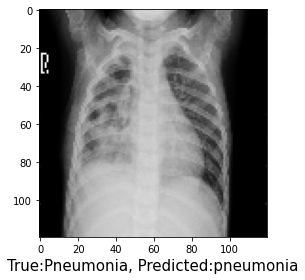

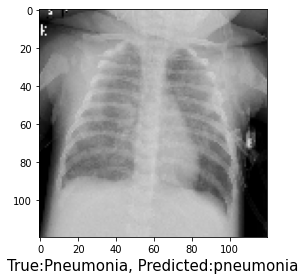

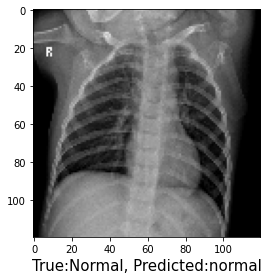

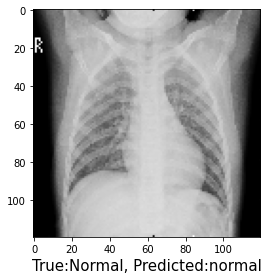

In [53]:
predict_image(validation_df, stacked_model)